In [1]:
import numpy as np
import time
from numpy.random import choice
from random import randint, random
import pickle
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# load two-qubit cliffords

infile = open('allGates', 'rb')
allGates = pickle.load(infile)
infile.close()
print("{} gates loaded".format(len(allGates)))

11520 gates loaded


In [3]:
from routines_aux import style, xzAdjacent, sym_inner_prod, check_invar
from routines_stab import initTab, gfunc, getDet, rowsum, measure, measure_tossResult, twoQubitClif
from routines_ent import entEntropy, gf2RowRed, gf2RowRedright, clippedgauge, \
                         check_clippedgauge, getEndpoints, entEntropyclipped
from routines_1D import simulate1D

In [17]:
# autoreloading
# without autoreloading, restart kernel and reload cell post module edits. Not sufficient to rerun cell!
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# turn on autoreloading
%autoreload 2

In [ ]:
# turn off autoreloading
%autoreload 0

#### note
Python functions pass arguments by reference, so gf2RowRed will modify the input matrix

Slicing:

a = b = [1, 2, 3]    
a = a[:2]  # The identifier `a` now points to a new object, nothing changes for `b`.

This results in a = [1, 2], b = [1, 2, 3]. To modify a slice object in place, 

a = b = [1, 2, 3]    
a[:] = a[:2]  # Updates the object in-place, hence affects all references.

This results in a = [1, 2], b = [1, 2].

since entEntropy() has the line: tab_red = tab[n:2*n, np.concatenate((np.array(A_comp), np.array(A_comp) + n))]

entEntropy() will not modify the input tableau

In [7]:
def plotEnt(entEnt, n=None, p=None, cut_size=None, cut_samples=None, reps=None):
    if reps is None:
        reps = 1
    plt.figure(figsize=(10,4))
    plt.plot(entEnt)
    plt.title("n = {}, p = {}, cut_size = {}, cut_samples = {}, reps={}".format(n, p, cut_size, cut_samples, reps))
    plt.xlabel('timestep')
    plt.ylabel('entanglement entropy')
    #plt.ylim([0,n/2])
    plt.grid(True)
    plt.show()

In [7]:
# testing 1D simulation and clipped gaauge

n = 8
entEnt, tab, _, n, _, _, _ = simulate1D(runtime = 50, n = n, p = 0.1, cut_size = None, cut_samples = 1, verbose = False)
tabRed = xzAdjacent(tab[n:2*n, :-1])

clipped = clippedgauge(tabRed)
print("in clipped gauge?", check_clippedgauge(clipped))

l_ends, r_ends = getEndpoints(clipped)
print(l_ends)
print(r_ends)

for i in range(n):
    print('qubit', i, 'entropy', entEntropyclipped(l_ends, r_ends, i))

style(clipped)

in clipped gauge? True
[0 1 2 2 3 3 4 4]
[0 1 6 5 7 6 7 5]
qubit 0 entropy 0
qubit 1 entropy 0
qubit 2 entropy 1
qubit 3 entropy 2
qubit 4 entropy 3
qubit 5 entropy 2
qubit 6 entropy 1
qubit 7 entropy 0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1
5,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0
6,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
7,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0


In [81]:
def simulate2D(runtime = 20, n = 6, p = 0, cut_size = None, cut_samples = 3, verbose = False):
    """
    open boundary conditions (OBC), valid for both odd and even n
    works on a square grid of n*n
    """

    if verbose:
        start = time.time()
        
    if cut_size is None:
        cut_size = n//2
    
    tab = initTab(n*n)
    entEnt = np.zeros(runtime) 
    
    for t in (tqdm(range(runtime)) if verbose else range(runtime)):
        
        # estimate entropy
        entEnt_sample = np.zeros(cut_samples, dtype=int)
        for i in range(cut_samples):
            #A = np.roll(range(n), randint(0,n))[:cut_size] # contiguous geometry PBC
            A = np.arange(0, randint(1,n-1)) # contiguous geometry OBC
            A = np.concatenate([A+n*row for row in range(n)]) # check this
            entEnt_sample[i] = entEntropy(tab, A)
        entEnt[t] = np.mean(entEnt_sample)

        # act with gates - horizontal links
        for i in range(0, n-1, 2):
            for j in range(0, n):
                twoQubitClif(tab, allGates[choice(len(allGates))], i+n*j, (i+1)+n*j)

        # measure
        for i in range(0, n*n):
            rand_num = random.random()
            if rand_num < p:
                measure_tossResult(tab, i)
                
        # act with gates - vertical links
        for i in range(0, n):
            for j in range(0, n-1, 2):
                twoQubitClif(tab, allGates[choice(len(allGates))], i+n*j, i+n*(j+1))
                
        # measure
        for i in range(0, n*n):
            rand_num = random.random()
            if rand_num < p:
                measure_tossResult(tab, i)
            
        # act with gates - alternate horizontal links
        for i in range(1, n-1, 2):
            for j in range(0, n):
                twoQubitClif(tab, allGates[choice(len(allGates))], i+n*j, (i+1)+n*j)
                    
        # measure
        for i in range(0, n*n):
            rand_num = random.random()
            if rand_num < p:
                measure_tossResult(tab, i)
                
        # act with gates - alternate vertical links
        for i in range(0, n):
            for j in range(1, n-1, 2):
                twoQubitClif(tab, allGates[choice(len(allGates))], i+n*j, i+n*(j+1))
                
        # measure
        for i in range(0, n*n):
            rand_num = random.random()
            if rand_num < p:
                measure_tossResult(tab, i)

    if verbose:
        print("runtime: {}".format(time.time() - start))
    
    return(entEnt, tab, runtime, n, p, cut_size, cut_samples)


runtime: 59.926518201828


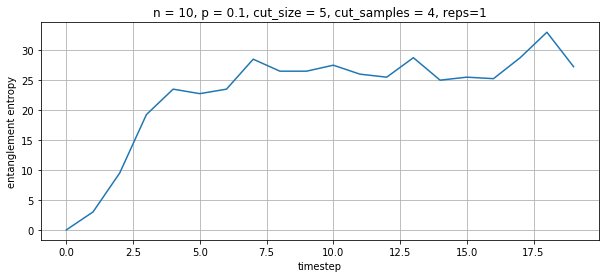

In [57]:
entEnt, tab, _, n, p, cut_size, cut_samples = simulate2D(runtime=20, n=10, p=0.1, cut_size=None, cut_samples=4, verbose=True)
plotEnt(entEnt, n, p, cut_size, cut_samples)


runtime: 19.55842399597168


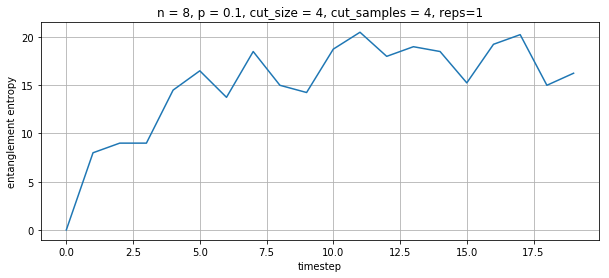

In [58]:
entEnt, tab, _, n, p, cut_size, cut_samples = simulate2D(runtime=20, n=8, p=0.1, cut_size=None, cut_samples=4, verbose=True)
plotEnt(entEnt, n, p, cut_size, cut_samples)


runtime: 4.254666328430176


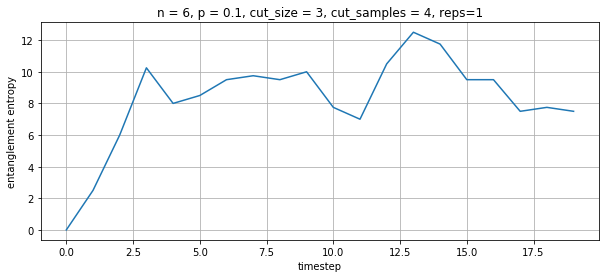

In [60]:
entEnt, tab, _, n, p, cut_size, cut_samples = simulate2D(runtime=20, n=6, p=0.1, cut_size=None, cut_samples=4, verbose=True)
plotEnt(entEnt, n, p, cut_size, cut_samples)


runtime: 7.282926797866821


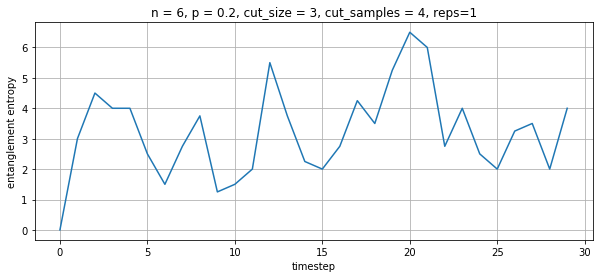

In [62]:
entEnt, tab, _, n, p, cut_size, cut_samples = simulate2D(runtime=30, n=6, p=0.2, cut_size=None, cut_samples=4, verbose=True)
plotEnt(entEnt, n, p, cut_size, cut_samples)


runtime: 39.4990930557251


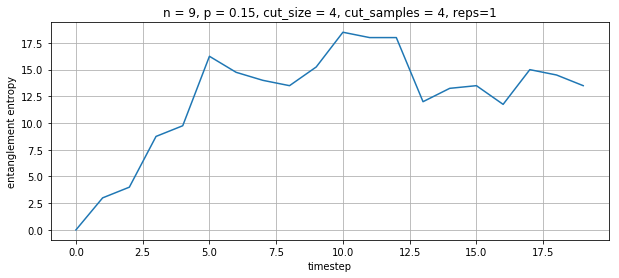

In [68]:
entEnt, tab, _, n, p, cut_size, cut_samples = simulate2D(runtime=20, n=9, p=0.15, cut_size=None, cut_samples=4, verbose=True)
plotEnt(entEnt, n, p, cut_size, cut_samples)

In [65]:
ns = [5,6,7,8,9]
# ps = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
ps = [0.1, 0.15, 0.2]
runtime = 20
ents = np.zeros((len(ns), len(ps), runtime))

for i in range(len(ns)):
    for j in range(len(ps)):
        print(ns[i], ps[j])
        entEnt, _, _, _, _, _, _ = simulate2D(runtime=runtime, n=ns[i], p=ps[j], cut_samples=ns[i]//2, verbose=True)
        ents[i,j,:] = entEnt

5 0.1



runtime: 1.8393478393554688
5 0.15



runtime: 1.8129570484161377
5 0.2



runtime: 1.9646987915039062
6 0.1



runtime: 4.2332680225372314
6 0.15



runtime: 4.582708120346069
6 0.2



runtime: 4.5989460945129395
7 0.1



runtime: 9.528194904327393
7 0.15



runtime: 10.367807865142822
7 0.2



runtime: 10.69853687286377
8 0.1



runtime: 18.184530019760132
8 0.15



runtime: 21.013356924057007
8 0.2



runtime: 20.00334906578064
9 0.1



runtime: 35.574498891830444
9 0.15



runtime: 38.65492391586304
9 0.2



runtime: 34.53725504875183


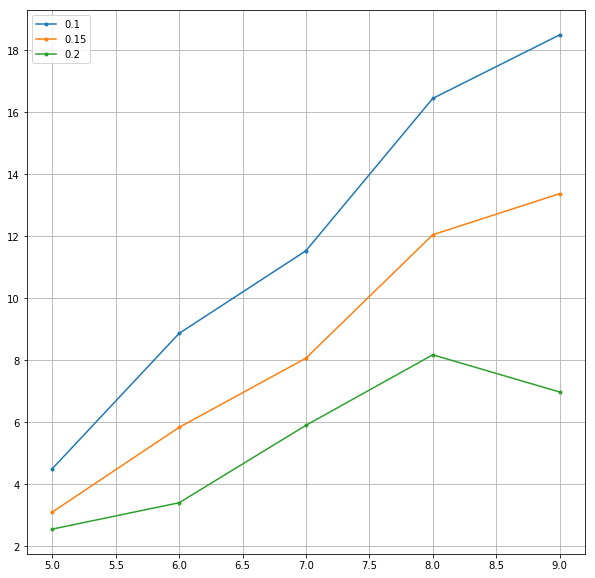

In [78]:
ents_equ = np.mean(ents[:,:,-10:], axis=2)
plt.figure(figsize=(10,10))
# plt.semilogy(ns, ents_equ, '.-')
plt.plot(ns, ents_equ, '.-')
plt.legend(ps)
plt.grid(True)

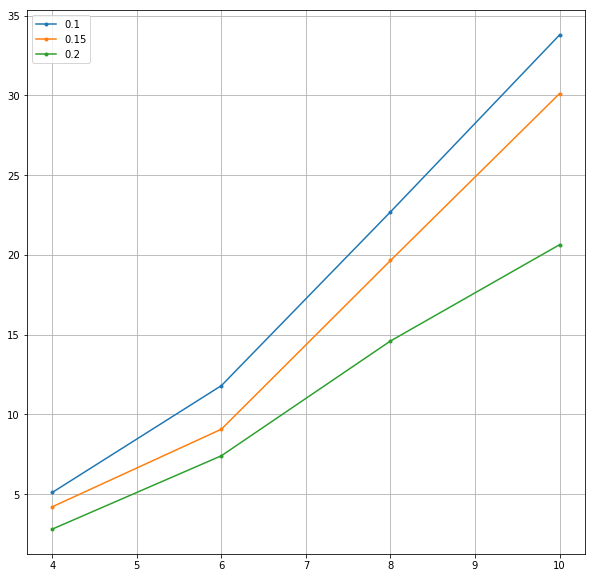

In [19]:
ents_equ = np.mean(ents[:,:,-5:], axis=2)
plt.figure(figsize=(10,10))
# plt.semilogy(ns, ents_equ, '.-')
plt.plot(ns, ents_equ, '.-')
plt.legend(ps)
# plt.xlim([4,10])
plt.grid(True)

In [172]:
print(ent_2d.shape)
print(ents[:,:,10:].shape)
print(np.vstack((ent_2d, ents[:,:,10:])).shape)

(5, 7, 20)
(1, 7, 20)
(6, 7, 20)


(5, 7)
[2, 4, 6, 8, 10]
[0]


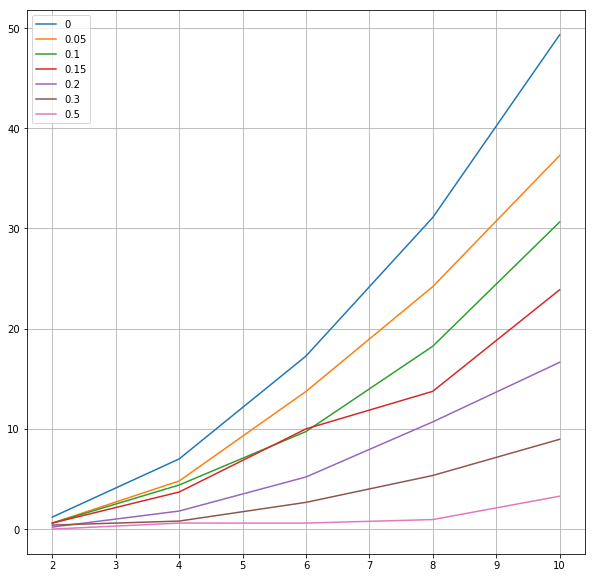

In [210]:
# outfile = open('ent_2d', 'wb')
# pickle.dump(np.vstack((ent_2d, ents)), outfile)
# outfile.close()

# infile = open('ent_2d', 'rb')
# ent_2d = pickle.load(infile)
# infile.close()

ents_equ = np.mean(ent_2d[:,:,-10:], axis=2)
# ents_equ = np.mean(np.vstack((ent_2d, ents[:,:,10:]))[:,:,-5:], axis=2)
print(ents_equ.shape)
print(ns)
print(ps)
# print(ents_equ)

plt.figure(figsize=(10,10))
# plt.semilogy(ns, ents_equ, '.-')
# plt.plot(ns, ents_equ, '.-')
plt.plot(ns, np.mean(ents0[:,:,-5:], axis=2))
plt.plot(ns, np.mean(ents005[:,:,-5:], axis=2))
plt.plot(ns, np.mean(ents01[:,:,-5:], axis=2))
plt.plot(ns, np.mean(ents015[:,:,-5:], axis=2))
plt.plot(ns, np.mean(ents02[:,:,-5:], axis=2))
plt.plot(ns, np.mean(ents03[:,:,-5:], axis=2))
plt.plot(ns, np.mean(ents05[:,:,-5:], axis=2))
plt.legend([0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5])
# plt.xlim([4,10])
plt.grid(True)